In [1]:
!pip install --upgrade setuptools==65.5.0
!pip install --quiet stable_baselines3
!pip install --quiet import_ipynb
!git clone https://github.com/gmshroff/aiagentarch.git
!pip install pyglet==1.5.27
%cd aiagentarch

fatal: destination path 'aiagentarch' already exists and is not an empty directory.
/Users/joykirat/Downloads/sem8/MTL/project/aiagentarch


In [35]:
import gym
from gym import spaces
from gym import Env
import random
import numpy as np
from threading import Thread
import threading
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv,VecFrameStack
from stable_baselines3.common.monitor import Monitor as Mon
from stable_baselines3.common.vec_env import StackedObservations
import random

In [36]:
# for thread in threading.enumerate(): 
#     print(thread.name)

In [37]:
# for thread in threading.enumerate(): 
#     print(thread.name)

### Agent-based RL in Simple Worlds

In [38]:
import import_ipynb
from aiagentbase import AIAgent,Controller,Memory,Perception,Actor

In [39]:
from cartpole_tasks import CartPoleEnv

In [40]:
env = CartPoleEnv()

In [41]:
class CartWorldMeta():
    def __init__(self,env):
        self.env=env
        self.test_episodes=[]
        self.world_over=False
    def stop(self):
        self.world_over=True
    def run_all(self,agent,perf,n_episodes=10,total_tasks=None,replay=None):
        if total_tasks is None:
            for g in perf:
                for l in perf[g]:
                    env.length,env.gravity=l,g
                    env.polemass_length = env.masspole * env.length
                    self.run(agent,n_episodes=n_episodes)
            return []
        elif replay is None:
            replay=[]
            for task in range(total_tasks):
                env.length=random.choice(list(perf[10].keys()))
                env.gravity=random.choice(list(perf.keys()))
                replay+=[(env.length,env.gravity)]
                env.polemass_length = env.masspole * env.length
                print(f'Task:{task},length:{env.length},gravity:{env.gravity}')
                self.run(agent,n_episodes=n_episodes)
            return replay
        else:
            for l,g in replay:
                env.length=l
                env.gravity=g
                env.polemass_length = env.masspole * env.length
                print(f'length:{env.length},gravity:{env.gravity}')
                self.run(agent,n_episodes=n_episodes)
            return replay
    def run(self,agent=None,n_episodes=10,episode_maxlen=1000):
        agent.observation_space=env.observation_space
        if 'training' not in agent.__dict__: agent.training=False
        if agent.training: testing=False 
        else: testing=True
        if agent.training: print('Starting Training time: ',agent.time)
        for episode in range(n_episodes):
            # print('CartAgent','starting episode')
            state=self.env.reset()
            agent.begin()
            # print(agent.time)#,agent.ep)
            for t in range(episode_maxlen):
                # print(f'length:{env.length},gravity:{env.gravity}')
                # env.render(mode='rgb_array')
                action=agent.act(state)
                # print(episode,t,'Action: ', action)
                state, reward, done, info = env.step(action)
                agent.reward((reward,done,info))
                # print(episode,t,'Reward sent: ', reward)
                if done:
                    break
            if self.world_over:break
            if not agent.training: self.test_episodes+=[episode]
            if not agent.training and not testing: 
                print('Training Over at time: ',agent.time)
                testing=True
                self.world_over=True
        print('Testing Done time: ', agent.time, ' Reward: ', agent.avg_rew())
        return agent.avg_rew()

In [42]:
class RandomAIAgent(AIAgent):
    def __init__(self,action_space):
        super().__init__()
        self.actor=self.Actor(parent=self)
        self.action_space=action_space
        self.tot_rew=0
        self.rewL=[]
        
    class Actor(Actor):
        def __init__(self,parent): 
            super().__init__(parent=parent)
        def call_model(self,state):
        ##Overriding AIAgent.Model
            # print(self.parent.action_space.sample())
            action = self.parent.action_space.sample()
            return action
        def compute_reward(self,reward):
            return reward[0]
    
    def reward(self,rew):
        ##Augmenting AIAgent
        self.tot_rew+=rew[0]
        return super().reward(rew)
    def begin(self):
        ##Augmenting AIAgent
        self.rewL+=[self.tot_rew]
        super().begin()
    def avg_rew(self):
        return sum(self.rewL)/len(self.rewL)

In [43]:
import pickle
with open('./perf.pickle','rb') as f: perf=pickle.load(f)

In [44]:
agent=RandomAIAgent(env.action_space)
agent.training=True

In [45]:
agent.debug=False
agent.use_memory=True

In [46]:
agent.limit_memory=True
agent.memory.limit_perceptual=2
agent.memory.limit_sar=4

In [47]:
world=CartWorldMeta(env=env)

In [48]:
# worldthread=Thread(name='world',target=world.run,args=(agent))

In [49]:
# worldthread.start()

In [50]:
r=world.run_all(agent,perf,total_tasks=20,replay=None)

Task:0,length:4.5,gravity:130
Starting Training time:  0
Testing Done time:  268  Reward:  107.4
Task:1,length:4.5,gravity:120
Starting Training time:  268
Testing Done time:  582  Reward:  257.7
Task:2,length:1.5,gravity:110
Starting Training time:  582
Testing Done time:  807  Reward:  397.6333333333333
Task:3,length:2.5,gravity:60
Starting Training time:  807
Testing Done time:  1117  Reward:  532.1
Task:4,length:3.75,gravity:180
Starting Training time:  1117
Testing Done time:  1407  Reward:  678.42
Task:5,length:4.0,gravity:90
Starting Training time:  1407
Testing Done time:  1734  Reward:  823.1166666666667
Task:6,length:0.5,gravity:20
Starting Training time:  1734
Testing Done time:  1968  Reward:  967.3428571428572
Task:7,length:3.75,gravity:130
Starting Training time:  1968
Testing Done time:  2263  Reward:  1107.4875
Task:8,length:4.25,gravity:190
Starting Training time:  2263
Testing Done time:  2544  Reward:  1248.3666666666666
Task:9,length:1.0,gravity:80
Starting Training

In [51]:
agent.avg_rew()/len(agent.ep)

13.399725

In [19]:
# agent.memory.perceptual_memory

: 

In [ ]:
with open('./replay.pickle','wb') as f: pickle.dump(r,f)

### Training an AI Agent's Model using Generic RL Agent

In [ ]:
from threading import Thread
import threading
import sys

In [ ]:
from queue import Queue

In [ ]:
from aiagentbase import RLAgent

In [ ]:
training_steps=1000000

In [ ]:
agent=RLAgent(algoclass=PPO,monclass=Mon,action_space=env.action_space,observation_space=env.observation_space,
              verbose=0,metarl=True,win=10,soclass=StackedObservations)

In [ ]:
agent.debug=False
agent.use_memory=True
agent.training=True

In [ ]:
agent.rewL=[]
agent.tot_rew=0

In [ ]:
agent.start(training_steps=training_steps)

In [ ]:
world=CartWorldMeta(env=env)

In [ ]:
# worldthread=Thread(name='world',target=world.run,args=(agent,2000,200))

In [ ]:
# worldthread.start()

In [ ]:
# len(agent.logL)

In [ ]:
# agent.time

In [ ]:
# agent.memory.sar_memory[10011]

In [ ]:
with open('./replay.pickle','rb') as f: replay=pickle.load(f)

In [ ]:
_=world.run_all(agent,perf,n_episodes=50,total_tasks=20,replay=replay)

length:3.75,gravity:20
Starting Training time:  0
Testing Done time:  2959  Reward:  1273.22
length:5.0,gravity:160
Starting Training time:  2959
Testing Done time:  4551  Reward:  2502.46
length:2.5,gravity:50
Starting Training time:  4551
Testing Done time:  6466  Reward:  3495.9933333333333
length:1.75,gravity:50
Starting Training time:  6466
Testing Done time:  8115  Reward:  4435.62
length:1.0,gravity:150
Starting Training time:  8115
Testing Done time:  9033  Reward:  5262.62
length:3.75,gravity:160
Starting Training time:  9033
Testing Done time:  10597  Reward:  6024.16
length:1.75,gravity:110
Starting Training time:  10597
Testing Done time:  11883  Reward:  6769.791428571429
length:0.75,gravity:100
Starting Training time:  11883
Testing Done time:  12937  Reward:  7472.4
length:1.0,gravity:20
Starting Training time:  12937
Testing Done time:  18040  Reward:  8318.282222222222
length:4.0,gravity:140
Starting Training time:  18040
Testing Done time:  19856  Reward:  9381.098
le

In [ ]:
# Without metarl training
agent.avg_rew()/len(agent.ep)

29.213291

In [ ]:
# With metarl training
agent.avg_rew()/len(agent.ep)

30.86993

In [ ]:
agent.training=False

In [ ]:
_=world.run_all(agent,perf,n_episodes=50,total_tasks=20,replay=replay)

length:3.75,gravity:20
Testing Done time:  112733  Reward:  33924.974285714285
length:5.0,gravity:160
Testing Done time:  114438  Reward:  37545.59909090909
length:2.5,gravity:50
Testing Done time:  162579  Reward:  41930.50869565218
length:1.75,gravity:50
Testing Done time:  212579  Reward:  47978.3625
length:1.0,gravity:150
Testing Done time:  227607  Reward:  54820.0936
length:3.75,gravity:160
Testing Done time:  229197  Reward:  61496.053076923075
length:1.75,gravity:110
Testing Done time:  267806  Reward:  68443.31185185185
length:0.75,gravity:100
Testing Done time:  317806  Reward:  76438.40785714285
length:1.0,gravity:20
Testing Done time:  367806  Reward:  85606.25586206897
length:4.0,gravity:140
Testing Done time:  369476  Reward:  95039.37666666666
length:0.75,gravity:170
Testing Done time:  374055  Reward:  103967.01741935484
length:2.25,gravity:10
Testing Done time:  424055  Reward:  113172.891875
length:5.25,gravity:190
Testing Done time:  425613  Reward:  122616.953939393

In [ ]:
# Without metarl testing
agent.avg_rew()/len(agent.ep)

51.27103375

In [ ]:
# With metarl testing
agent.avg_rew()/len(agent.ep)

94.84685825000001

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
# testing_len=len([agent.rewL[t] for t in world.test_episodes])

In [ ]:
# testing_len

In [ ]:
# agent.rewL

In [ ]:
# print(np.gradient(agent.rewL).mean())

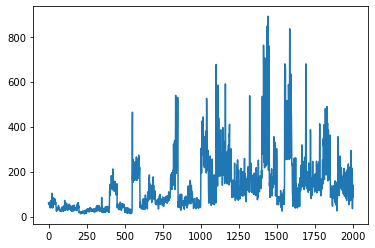

In [ ]:
# Without metarl 
plt.plot(np.gradient(agent.rewL))

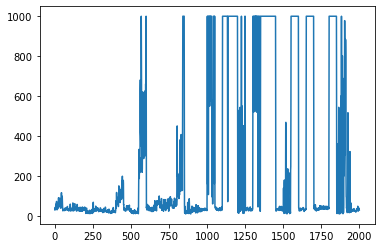

In [ ]:
# With metarl 
plt.plot(np.gradient(agent.rewL))

In [ ]:
episodes = 50
rewL=[]
for episode in range(1, episodes+1):
    state = env.reset()
    done = False
    score = 0 
    steps=0
    while not done and steps<=200:
        env.render()
        action=agent.act(state)
        # action,_ = agent.model.predict(state)
        state, reward, done, info = env.step(action)
        score+=reward
        steps+=1
    # print('Episode:{} Score:{}'.format(episode, score))
    rewL+=[score]
env.close()

In [ ]:
print(np.array(rewL).mean())

In [ ]:
plt.plot(rewL)